## Sequência de funções valor para os credores

Queremos resolver por indução retroativa um jogo com T períodos.

Estou trabalhando em como deixar esse jogo em torno do parâmetro T

Teremos duas sequências de funções valor: uma para quando apenas o credor sênior propõe e outra para quando apenas o credor júnior propõe. As funções do jogo final serão uma média ponderada destas.



In [157]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [158]:
#libraries
import numpy as np
from numba import jit, jitclass, float64, njit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

from random import uniform #para a draw da uniforme(0,1)
import math

import time #tempo de computação


### Passo 0: definindo comandos do latex para facilitar a escrita

$%conjunto de informações de s em t$
$\newcommand{\Is}[1]{\theta_{s{#1}}, l_{s{#1}}, l_{j{#1}}}$
$%macros para facilitar a escrita de funções valor$


$%conjunto de informações de j em t$
$\newcommand{\Ij}[1]{\theta_{j{#1}}, l_{s{#1}}, l_{j{#1}}}$

$%função valor de s em t$
$\newcommand{\Ws}[1]{ W_{s{#1}} ( \Is{{#1}}) }$

$%função valor de j em t$
$\newcommand{\Wj}[1]{ W_{j{#1}} ( \Ij{{#1}}) }$

$%operador esperança de s em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \mid ( \Is{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b de big para aumentar os parênteses$
$\newcommand{\esb}[2]{\mathbb{E_{#1}^{s} \bigg[ {#2}  \bigg] }}$

$%operador esperança de j em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \mid ( \Ij{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b para aumentar os parênteses$
$\newcommand{\ejb}[2]{\mathbb{E_{#1}^{j} \bigg[ {#2}  \bigg] }}$


$%comando para usar o máximo com chaves grandes$
$\newcommand{\maximo}[1]{\max \bigg\{ #1 \bigg\}}$


In [159]:
#parâmetros do jogo, apenas para ilustração a princípio
#coloquei os mesmos parãmetros dos autores (Tabela 4). No caso dos dados, usei as médias (Panel B)





μ = 4.566 #número de meses entre períodos, não entendi onde entra ainda
ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


θ_s0 = 0.28 #habilidade inicial de s
θ_j0 = 0.36 #habilidade inicial de j

In [160]:
#informações que virão dos dados

#valores médios de L, Dj e Ds. Arredondei para duas casas decimais ao simular o modelo
# 0.2493718592964824
# 0.35113065326633164
# 0.27701005025125625



λj = 0.346 #probabilidade de j propor a cada turno. Não precisaremos estimar, isso virá dos dados

Vmax = 1
L = 0.25
# L_s = 10
# L_j = 10

#valores da dívida de cada jogador (virá dos dados, aqui é exemplo):
Dj = 0.35
Ds = 0.28

### Passo 1: número máximo de turnos

Calculado com base nos parâmetros


t é tal que

$$ \rho^{t-1} V_{max} = L$$


$$ t = \frac{log(L) - log(V_{max})} {log(\rho)} +1 $$

In [161]:
#função para calcular o máximo de turnos do jogo
def maximo_de_turnos(ρ, Vmax, L):
    
    T = (math.log(L) - math.log(Vmax))/math.log(ρ) + 1
    
    #arredonda para baixo porque queremos o último período no qual o valor de continuação é maior ou igual ao de liquidação
    T = math.floor(T)
        
    return T
    

In [162]:
T = maximo_de_turnos(ρ, Vmax, L)

T

12

In [163]:
#valor máximo de reorganização da firma a cada período


#sequência de valores da firma para cada período
#tem que deixar como dtype = np.float para pegar valores decimais

def Vt(Vmax, T, ρ):
    
    

    V = np.empty(T, dtype=np.float)

    for t in range(T):
        
        #no período t = 0, ela é o Vmax. E no período t = 1, também, pois não depreciou ainda

        if(t == 0):
            V[t] = Vmax

        else:
            V[t] = ρ**(t-1) * Vmax
            
    return V

V = Vt(Vmax, T, ρ)

In [164]:
#valor de liquidação


#a dívida total é sempre a soma das dívidas
D = Ds + Dj

#o custo total é uma função do tempo

def C(t):
    if(t == 0):
        return 0
    else:
        Ct = c0 * D + c1 * t * D

        return Ct

#e os valores de liquidação também são função do tempo

def Ls(t):
    
    Lst = min(L - C(t), Ds)
    
    return Lst


def Lj(t):
    
    Ljt = min(L - C(t) - Ls(t), Dj)
    
    return Ljt
    
    


### Passo 2: Definir os arrays para guardar as funções valor de cada período

São:

* 100 slots para habilidade do jogador

* 100 slots para o lower bound do adversário

* 100 slots para o lower bound do próprio jogador no próximo período

* 2 slots para dizer se o jogador está propondo ou não
    
* T slots para marcar o período da função valor



In [165]:
#slots para cada habilidade
grid_size = 100


#a vantagem de colocar os dados assim é que se eu quiser teta_s = 0.115, basta procurar θs_vals[114]
θs_vals = np.linspace(0.01, 1, grid_size) 
θj_vals  = np.linspace(0.01, 1, grid_size)  


#vetores dos lower bounds são similares aos das habilidades
ls_vals = θs_vals
lj_vals = θj_vals

#teste
# θs_vals[99 - 1]

#como deixar todos os valores com apenas duas casas decimais? Alguns valores ficam esquisitos



In [166]:
#arrays para o credor sênior



# primeira entrada é a habilidade verdadeira do jogador
# segunda entrada é lst
# terceira entrada é ljt

# quarta entrada indica se jogador está propondo (1) ou respondendo (0)
# última entrada é o período do jogo

Ws_array = np.zeros((100, 100, 100, 2, T))

Wj_array = np.zeros((100, 100, 100, 2, T))

#vou deixar a função policy separada porque ela vai ser um resultado da barganha entre os agentes



In [167]:
#uma das sugestões que encontrei no stack overflow foi de dividir a matriz grandona em várias matrizes pequenas
#vou tentar com 100x100x100 primeiro, depois eu adapto o código

# Ws_array1 = np.empty((100, 100, 100,T))
# Ws_array2 = np.empty((100, 100, 100,T))
# Ws_array3 = np.empty((100, 100, 100,T))
# Ws_array4 = np.empty((100, 100, 100,T))
# Ws_array5 = np.empty((100, 100, 100,T))
# Ws_array6 = np.empty((100, 100, 100,T))
# Ws_array7 = np.empty((100, 100, 100,T))
# Ws_array8 = np.empty((100, 100, 100,T))
# Ws_array9 = np.empty((100, 100, 100,T))


Populando o array com os valores de liquidação, que independem das habilidades ou lower bounds



In [168]:
Ws_array[:,:,:, :,(T-1)] = Ls(T)

Wj_array[:,:,:, :,(T-1)] = Lj(T)

In [169]:
#funções para achar os valores nas matrizes

def Ws_find(teta_st, lst, ljt, policy, t):
    
    
    #para achar teta_st = 0.99, buscamos: θs_vals[99 - 1]
    #como os valores serão em casas decimais, temos que multiplicar por 100
    vteta_st = int(100 * teta_st - 1)
    
    vlst = int(100 * lst - 1)
    
    vljt = int(100 * ljt - 1)
    
    return Ws_array[vteta_st, vlst, vljt,policy, t]
    
    

    
def Wj_find(teta_jt, lst, ljt, policy, t):
    
    
    vteta_jt = int(100 * teta_jt - 1)
    
    vlst = int(100 * lst - 1)
    
    vljt = int(100 * ljt - 1)
    
    return Ws_array[vteta_jt, vlst, vljt, policy, t]



def find(y):
    
    x = 100*y - 1
    
    #transformando em int para usar como índice nas matrizes
    
    x = int(x)
    
    return x


### Passo 3: fazer o cálculo das funções valor em T-1, T-2, ..., 1.

### Função para tirar um draw da distribuição Beta


Vamos usar o método da amostragem da inversa da CDF (https://en.wikipedia.org/wiki/Inverse_transform_sampling_method). Outra referência que usei foi: https://blogs.sas.com/content/iml/2013/07/22/the-inverse-cdf-method.html#:~:text=The%20exponential%20distribution%20has%20probability,log(1%E2%80%93u).

A CDF da Beta é 

$$ F_{\beta} ( \theta_{t+1} \mid \theta_{t} ) = 1 - \frac{ (1 - \theta_{t+1})^\beta}{ (1 - \theta_{t})^\beta }, \, \, \theta_{t} \leq \theta_{t+1} \leq 1, \, \beta \geq 1$$

Para invertê-la, basta procurarmos o valor de x tal que $F(x) = u$, onde u é uma retirada da distribuição Uniforme(0,1).

Fazendo os cálculos, esse valor de x é (ou $\theta_{t+1}$, no caso)


$$ \theta_{t+1} =  1 - exp \bigg\{ \frac{1}{\beta} \big[  log (1 - u) + \beta * log(1 - \theta_{t}) \big] \bigg\} $$


In [170]:
#código para tirar draw da distribuição beta

def draw_beta(info_hoje):
    
    
    #se for igual a 1, retorna 1. Não usei a fórmula da inversa CDF porque teríamos log (0)
    if(info_hoje == 1):
        return 1
    else:
    
        u = uniform(0, 1)
        x = 1 - math.exp( (1/β) * (math.log(1-u) + β*math.log(1-info_hoje)) )

        return x




# testando

# draw_beta(0.5)



# #teste com draw da função UNIFORME
# def draw_beta(info_hoje):
#     u = uniform(info_hoje, 1)
#     return u


# # testando
# draw_beta(0.99)

### Função para tirar o valor esperado do teta amanhã, dada a informação hoje.

Usamos a forma fechada, baseada na esperança de uma variável aleatória truncada: https://en.wikipedia.org/wiki/Truncated_distribution



$$ \mathbb{E} \big[ X \mid X > y \big] =  \frac{\int_{y}^{\infty}  x g(x) dx} {1 - F(y)} $$


Onde:

* $f(x)$ é a pdf da Beta, sem truncar. No caso, usamos a = 1 e b = $\beta$
* $ g(x) = f(x)$ sempre que $x > y$ e 0 caso contrário
* $F(y)$ é a CDF da Beta, sem truncar, avaliada em y


Em nosso caso, y será a informação que temos hoje para formar a expectativa sobre a habilidade amanhã. Na prática, y será ou a habilidade do credor no período atual $\theta_{k,t}, k \in \{s,j\}$ ou o lower bound da habilidade do credor adversário no período atual $l_{k,t}$.

Ilustraremos a fórmula usando $l_{t}$:

<!-- 
$$ \mathbb{E} \big[ \theta_{t+1} \mid \theta_{t+1} > l_t \big] =  \frac{ l_t (1 - l_t)^\beta + \frac{(1-l_t)^{\beta+1} }{(\beta+1)} } {1 - (1 - l_t)^\beta} $$ -->



$$ \mathbb{E} \big[ \theta_{t+1} \mid \theta_{t+1} > l_t \big] =  \frac{ l_t (1 - l_t)^\beta + (1-l_t)^{\beta+1}(\beta+1)^{-1} } {(1 - l_t)^{\beta} } $$



In [171]:
def expec_beta(info_hoje):
    
    #retorna 1 se a info_hoje for 1. A CDF não suporta 1
    if info_hoje == 1:
        return 1
    else:
        num = info_hoje * (1 - info_hoje)**β + ((1-info_hoje)**(β+1))/(β+1)

        denom = (1-info_hoje)**(β)

        return round(num/denom,2)
    

# testando, com beta = 1 e lt = 0.5, deve achar 0.75


# expec_beta(0.5)


# #para os outros valores, não pode ser superior a 1. E tem que ser crescente
# expec_beta(0.3)

# expec_beta(0.99)
# expec_beta(1)

In [172]:
# def expec_beta(info_hoje):
    

#     #para calcular o valor esperado UM PERÍODO À FRENTE, vamos tirar 1000 draws disso e fazer a média
#     #se estiver correto, expec_beta(0.5, 1) deve ser próximo de 0.75, pois Beta = 1 é Uniforme
#     beta_vals = []

#     for t in range(100):
#         beta_amanha = draw_beta(info_hoje)

#         beta_vals.append(beta_amanha)
        
#     return round(np.mean(beta_vals),2)

# #testando
# # expec_beta(0.5)



#teste com draw da função UNIFORME
# def expec_beta(info_hoje):
    
#     summation = 1/2
    
#     resultado = info_hoje/2 + summation
    
#     return round(resultado,2)

#testando
# expec_beta(0.5)

### Como obter o valor esperado da função valor no período seguinte?

Multiplicando a coluna correta de pmf pela coluna correta de Ws_array


Agora que temos a pdf, podemos fazer assim:


$$ \es{t}{ \Ws{t+1} } = \sum_{\theta_{t+1}=0.01}^{1.00} prob(\Is{t+1}) * \Ws{t+1}$$


Na prática, já saberemos $l_{s,t+1}$ e $l_{j,t+1}$, então poderemos fixar esses valores


$$ \es{t}{ \Ws{t+1} } = \sum_{\theta_{t+1}=0.01}^{1.00} prob(\theta_{t+1}) * [ \Ws{t+1} \mid l_{s,t+1}, l_{j,t+1} ]$$


Vamos fazer essa soma usando multiplicação de vetores:

* aproveitaremos que dá pra saber os lower bounds do período seguinte a cada situação, então a única incerteza é sobre teta
* multiplicaremos pmf (vetor linha)
* pelo vetor coluna W correspondente


Como achar a entrada correspondente na matriz?
Por exemplo, achar qual entrada corresponde a lst =  0.58. Basta escrever 57 na entrada correspondente. Ou usar a função find(0.58).




In [173]:
#binning da pdf beta

#gerando 1000 draws

def bin(info_hoje, ndraws):
    
    beta_vals = []

    for k in range(ndraws):
        beta_amanha = draw_beta(info_hoje)

        beta_vals.append(beta_amanha)
    
    #cria os bins e conta quantos valores estão dentro deles
    teta_bins = np.zeros(len(θj_vals))  
    
    for t in range(len(teta_bins)):
        
        #ajustando os bins iniciais e final
        if(t==0):
            pre = 0
        else:
            pre = (θj_vals[t-1]+θj_vals[t])/2
               
        
        if(t==len(teta_bins)-1):
            pos = 1
        else: 
            pos = (θj_vals[t]+θj_vals[t+1])/2
        
        
        for b in beta_vals:
            
            if(b >= pre and b <= pos):
                
                teta_bins[t] += 1
    
    return teta_bins/ndraws
        
        
        
        
#às vezes soma um pouco a mais que um (tipo a sétima casa decimal fica maior que zero, mas ok)
# sum(bin(0.9,1000))




In [174]:
#vamos gerar uma matriz com 100 linhas e 100 colunas
#cada coluna vai representar as probabilidades de teta_amanhã dado teta hoje
#a linha 1 significa que teta_hoje é 0.01
#assim, a linha 1 tem as probabilidades de teta_amanhã dado que teta_hoje é 0.01




#probability mass function
pmf = np.zeros((100,100))

#exemplo para ilustrar
# pmf[0,] = bin(θj_vals[0], β, 1000)


#populando a pmf:

for t in range(len(θj_vals)):
    
    pmf[t,:] = bin(θj_vals[t], 1000)

#quais as probabilidades de teta_amanhã se eu sei que teta_hoje = 0.5?

# sum(pmf[53,:])

In [175]:
#teste eliminando valores abaixo de teta_hoje


pmf[54,:]

pmf[54, 54:100]

sum(pmf[54, 54:100])

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.104, 0.155, 0.173, 0.118, 0.096, 0.082, 0.05 , 0.047, 0.036,
       0.033, 0.026, 0.021, 0.017, 0.013, 0.013, 0.008, 0.003, 0.002,
       0.002, 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

array([0.104, 0.155, 0.173, 0.118, 0.096, 0.082, 0.05 , 0.047, 0.036,
       0.033, 0.026, 0.021, 0.017, 0.013, 0.013, 0.008, 0.003, 0.002,
       0.002, 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

1.0000000000000002

In [176]:
#valor esperado das funções valor, já organizado

def Ews(teta_hoje, ls_amanha, lj_amanha, t):
    #t é o período para o qual queremos o valor esperado
    #t igual a "t_amanhã"
    
    if t == T:
        return Ls(T)
    else:
    
        teta_hoje = find(teta_hoje)

        ls_amanha = find(ls_amanha)
        lj_amanha = find(lj_amanha)
    
    
        
        Esp_respondendo = sum(pmf[teta_hoje, teta_hoje:100] * Ws_array[teta_hoje:100,ls_amanha, lj_amanha, 0, (t-1) ])
        Esp_propondo = sum(pmf[teta_hoje, teta_hoje:100] * Ws_array[teta_hoje:100,ls_amanha, lj_amanha, 1, (t-1) ])


        Esp = λj * Esp_respondendo + (1 - λj) * Esp_propondo

        return Esp


def Ewj(teta_hoje, ls_amanha, lj_amanha, t):
    
#     breakpoint()
    if t == T:
        return Lj(T)
    else:
        teta_hoje = find(teta_hoje)

        ls_amanha = find(ls_amanha)
        lj_amanha = find(lj_amanha)
    
    
    
        Esp_respondendo = sum(pmf[teta_hoje, teta_hoje:100] * Wj_array[teta_hoje:100,ls_amanha, lj_amanha, 0, (t-1) ])
        Esp_propondo = sum(pmf[teta_hoje, teta_hoje:100] * Wj_array[teta_hoje:100,ls_amanha, lj_amanha, 1, (t-1) ])

        #aqui invertemos a ordem porque j propõe com chance lambda_j
        Esp = λj * Esp_propondo  + (1 - λj) * Esp_respondendo

        return Esp


#teste


# start = time.process_time()


# Ews(0.5, 0.3, 0.2, 16)
# print(time.process_time() - start)

# sum(pmf[49, :] * Ws_array[49,29, 19, 1, 15])


#### Primeiro vamos explicar os cálculos, depois a gente explica a notação de matriz mais adiante


A primeira parte da função valor de s é caso ele venha a propor:


 $$ S_1 (\Is{1}) = \max \bigg\{ L_{s1}, V \es{1}{\theta_s} - \es{1}{W_j}, \es{1}{W_s}
                    \bigg\} $$



Lógica para calcular o lj_next:

lj_next = max{ljt, cjt}

Pensei no caso de cada um ser o máximo:
1. Se ljt > cjt, ou seja, se o lower bound de j não muda, podemos calcular o valor esperado de j usando ljt.
    * Daí que Pst = Ewj(expec_beta(ljt), ls_next, ljt, t+1)

2. Se existe cjt > ljt, então devemos achá-lo no loop:
    * Pst - Ewj(cjt, ls_next, cjt, t+1) > tol ...)
    * cjt inicial é ljt, daí que se ljt não faz screening, então Pst - Ewj(cjt, ls_next, cjt, t+1) < 0 e o loop para
3. Caso exista cjt > ljt, então lj_next = cjt, então calculamos novamente:
    * Pst = Ewj(expec_beta(ljt), ls_next, lj_next, t+1)
    * Se não existir esse cjt, lj_next = ljt, então Pst não mudará


In [177]:
#payoff de S quanto ele tem o direito de propor em t

 
#Tem que ter preparado o terreno antes calculando as funções valor no período seguinte

def St(teta_st, lst, ljt, t):
    
    #update do lower bound:
    
    #ls_next é a habilidade dele hoje, pois s revela esta quando propõe
    
    ls_next = teta_st
    
      
    
    #quanto s pagará para j neste período? A esperança da função valor de j amanhã,
    #calculadas de acordo com os lower bounds de amanhã
    
    
    #tem expec_beta porque eu não sei o valor de θjt+1, então estimo usando a informação de hoje
    Pst = Ewj(expec_beta(ljt), ls_next, ljt, t+1)
    
    
    #lj_next depende do cutoff de j
    
    #algoritmo para calcular cutoff
    
    cjt = ljt
    
    
    #flag vai parar o loop se demorar muito
    flag = 1
    tol = 0.01
    
    #condição cjt < 0.99 é pra ele não passar de 1
    #veja o que acontece com st(0.28, 0.51, 0.28, 14) se não tiver essa condição
    while (Pst - Ewj(cjt, ls_next, cjt, t+1) > tol and flag < 10000 and cjt < 0.99):
        cjt = cjt + 0.01
        flag = flag + 1
        
    
    #lj_next é o máximo entre o lower bound de j hoje e o cutoff de j
    lj_next = max(ljt, cjt)
    
    #aqui calculamos a oferta ótima de novo, pois pode ser que o cutoff seja maior que o lower bound anterior
    #vou deixar sem recalcular. Assim, é como se o pagamento fosse função de ljt
    
#     Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)
    
    #esperança da própria habilidade no próximo período
    θs_next = expec_beta(teta_st)
    
    #OLHAR ESSA PARTE COM CUIDADO, CONFERIR OS ARGUMENTOS DAS FUNÇÕES NO PERÍODO SEGUINTE
    #conferi em 05/08 e parece OK
    St = [Ls(t), V[t] * θs_next - Pst, Ews(θs_next, ls_next, lj_next, t+1)]
          
    
    policy_St = np.argmax(St)
    
    
    #retorna um vetor: a função valor, a política ótima, o ls_next, e o lj_next
    return St[policy_St],policy_St, ls_next, lj_next



Quando j propõe é análogo

In [178]:
#payoff de S quanto ele tem o direito de propor em t

 
#Tem que ter preparado o terreno antes calculando as funções valor no período seguinte

def Jt(teta_jt, lst, ljt, t):
    
    #update do lower bound:
    
    #ls_next é a habilidade dele hoje pois s revela esta quando propõe
    
    lj_next = teta_jt
    
      
    
    #quanto s pagará para j neste período? A esperança da função valor de j amanhã, conforme as informações de j hoje.
    
    Pjt = Ews(expec_beta(lst), lst, lj_next, t+1)
    
    
    #lj_next depende do cutoff de j
    
    #algoritmo para calcular cutoff
    
    cst = lst
    
    
    #flag é vai parar o loop se demorar muito
    flag = 1
    tol = 0.01
    
    while (Pjt - Ews(cst, cst, lj_next, t+1) > tol and flag < 10000 and cst < 0.99):
        cst = cst + 0.01
        flag = flag + 1
        
    
    #lj_next é o máximo entre o lower bound de j hoje e o cutoff de j
    ls_next = max(lst, cst)
    
    
    #aqui calculamos a oferta ótima de novo, pois pode ser que o cutoff seja maior que o lower bound anterior
    
#     Pjt = Ews(expec_beta(ls_next), ls_next, lj_next, t+1)
    
    #esperança da própria habilidade no próximo período
    θj_next = expec_beta(teta_jt)
    
    Jt = [Lj(t), V[t] * θj_next - Pjt, Ewj(θj_next, ls_next, lj_next, t+1)]
          
    
    policy_Jt = np.argmax(Jt)
    
    
    #retorna um vetor: a função valor, a política ótima, o ls_next, e o lj_next
    return Jt[policy_Jt],policy_Jt, ls_next, lj_next


    

    


A segunda parte da função valor é se se for chamado a responder:
    
$s_1 (\Is{1}) = $
    $ \esb{1}{ Prob ({j liquidar})  \maximo{L_{s1}, V \es{1}{\theta_s} - L_{j1}} } $
    $ + \esb{1}{ Prob ({j reorganizar})   \maximo{\ej{1}{W_s}, \es{1}{W_s}}    }$
 
 
 Sendo que
 
 $ \Es{1}{Prob (j liq em T-1)}$
 
  $$ = Prob \bigg(L_{j1} > \max \{V \es{1}{ \ej{1}{\theta_j} } - \es{1}{ \ej{1}{W_s} }, \es{1}{ \ej{1}{W_j}  }\} \bigg)$$
  
  
 Repare que $L_{j1} > L{j}$ e que $\es{1}{\theta_{j}}$ cresce em $\theta_{j}$. Então deve existir um threshold de reorganização em t = T-1, $\phi_{j1}$, tal que: 

$$V \phi_{j1} - L_{s} = L{j1} $$

$$ \phi_{j1} = \frac{ L_{j1} + L_{s} }{V} $$

Então se $\es{1}{\theta_{j}} > \phi_{j1}$, j reorganiza a firma. E j liquida a firma caso contrário.


A pergunta é: qual a probabilidade de que $\theta_{j}$ tome um valor menor ou igual a $\phi_{j1}$ ? Isso pode ser respondido usando a \textit{prior} do jogador, a função CDF da distribuição Beta:

$$ \Es{1}{Prob (\textnormal{j liq em T-1})} = F_{\beta} \big( \phi_{j1} \mid l_{j1} \big) $$
 


Na probabilidade de liquidar no período seguinte, temos a seguinte expressão:

$ Prob \bigg( L_{j,t} > \maximo{V_{t+1} \es{t}{\theta_{j,t+1} }  - \es{t}{ \ej{t}{ W_{s,t+1}  } }  ,  \es{t}{ \ej{t}{ W_{j,t+1}  } } } \bigg)$

Onde os termos dentro das expectativas iteradas são calculados com base apenas nos lower bounds de hoje.

1. Vamos considerar o caso em que a esperança de j sobre a sua própria função valor  é o máximo dos argumentos

2. Vamos calcular o threshold para o caso onde ainda pode compensar reorganizar a firma

In [179]:
#vamos criar os componentes da função st

#não preciso me preocupar com if t == T, pois esta condição estará nas funções valor Ws e Wj


#DÚVIDA SE AQUI EU PRECISO USAR LJ_NEXT E LS_NEXT.
            #ACHO QUE SIM, VOU CONFERIR DEPOIS
    
#05/08: acho que precisa usar lj_next e ls_next sim, então inputei esses valores nela lá na função st() mais à frente
#mudei os argumentos para ls_next, lj_next

def Prob_s(teta_st, ls_next, lj_next, t):
    
    #probabilidade de j liquidar em t, dado lj_next 
    #sob a ótica de s, daí o subscrito _s
    
    #caso onde a esperança de j sobre a própria função é o máximo dos argumentos
    if (Ewj(expec_beta(lj_next), ls_next, lj_next, t+1) > V[t] * 1 - Ews(expec_beta(ls_next), ls_next, lj_next, t+1) ):
        
        #se a esperança da função valor amanhã for maior ou igual ao valor de liquidar,
        #a chance de liquidar é zero
        
        if(Ewj(expec_beta(lj_next), ls_next, lj_next, t+1) >= Lj(t)):
            return 0
        else: 
            return 1
        
    #caso onde ainda compensa para j reorganizar a firma
    else:
        
        if(lj_next == 1):
            #se o lowerbound de j for igual a um e ainda compensar reorganizar a firma
            #a chance de j liquidar será zero
            return 0
        
        else:

            #threshold para j tentar liquidar

            #DÚVIDA SE AQUI EU PRECISO USAR LJ_NEXT E LS_NEXT.
            #ACHO QUE SIM, VOU CONFERIR DEPOIS
            ϕjt = ( Lj(t) + Ews(expec_beta(ls_next), ls_next, lj_next, t+1) ) / V[t]

            Prob_st = 1 - ((1 - ϕjt)**β)/((1 - lj_next)**β)

            #aqui tem que ser no mínimo a igual a zero, apenas por segurança
            Prob_st = max(0, Prob_st)

            return Prob_st
    
#testando
# Prob_s(0.5, 0.5, 1, 3)



A probabilidade para j é análoga

In [180]:
#vamos criar os componentes da função st

#não preciso me preocupar com if t == T, pois esta condição estará nas funções valor Ws e Wj

def Prob_j(teta_jt, ls_next, lj_next, t):
    
    #probabilidade de s liquidar em t, dado ls_next 
    #sob a ótica de j, daí o subscrito _j
    
    #caso onde a esperança de s sobre a própria função é o máximo dos argumentos
    if (Ews(expec_beta(ls_next), ls_next, lj_next, t+1) > V[t] * 1 - Ewj(expec_beta(lj_next), ls_next, lj_next, t+1) ):
        
        #se a esperança da função valor amanhã for maior ou igual ao valor de liquidar,
        #a chance de liquidar é zero
        
        if(Ews(expec_beta(ls_next), ls_next, lj_next, t+1) >= Ls(t)):
            return 0
        else: 
            return 1
        
    #caso onde ainda compensa para j reorganizar a firma
    else:
        
        if(ls_next == 1):
            #se o lowerbound de j for igual a um e ainda compensar reorganizar a firma
            #a chance de j liquidar será zero
            return 0
        else:

            #threshold para j tentar liquidar

            #DÚVIDA SE AQUI EU PRECISO USAR LJ_NEXT E LS_NEXT.
            #ACHO QUE SIM, VOU CONFERIR DEPOIS
            ϕst = ( Ls(t) + Ewj(expec_beta(lj_next), ls_next, lj_next, t+1) ) / V[t]

            Prob_jt = 1 - ((1 - ϕst)**β)/((1 - ls_next)**β)

            #aqui tem que ser no mínimo a igual a zero, apenas por segurança
            Prob_jt = max(0, Prob_jt)

            return Prob_jt

#teste
# Prob_j(0.5,0.5, 1, 3)

Payoff de s caso ele responda à uma proposta de liquidação de j

In [181]:
#Payoff de s caso ele responda à uma proposta de liquidação de j

def s_liq(teta_st, lst, ljt, t):
    
    #update dos lower bounds não é necessário aqui
    #é a unica parte da função que independe das funções valor no período seguinte
    
    st_liq = [Ls(t), V[t] * expec_beta(teta_st) - Lj(t) ]

    policy_st_liq = np.argmax(st_liq)


    st_liq = st_liq[policy_st_liq]

    return (st_liq),policy_st_liq




Payoff de j caso ele responda à uma proposta de liquidação de s

In [182]:
#Payoff de j caso ele responda à uma proposta de liquidação de s
#DÚVIDA se não seria
#jt_liq = [Lj(t-1), V[t] * teta_jt - Ls(t-0) ]
#ver página 56 Dou et al julho

def j_liq(teta_jt, lst, ljt, t):
    
    #update dos lower bounds não é necessário aqui
    #é a unica parte da função que independe das funções valor no período seguinte
    
    jt_liq = [Lj(t), V[t] * expec_beta(teta_jt) - Ls(t) ]

    policy_jt_liq = np.argmax(jt_liq)


    jt_liq = jt_liq[policy_jt_liq]

    return (jt_liq), policy_jt_liq




payoff caso s responda à uma proposta de reorganização de j


In [183]:
#payoff caso s responda à uma proposta de reorganização de j

def s_reorg(teta_st, lst, ljt, t):
    #update dos lower bounds
    
    
    #neste caso quem revela a informação é j,
    #vamos ter que colocar o update do lower bound na estrutura da barganha do jogo depois
    lj_next = expec_beta(ljt)
    
    #algoritmo para calcular cutoff
    
    cst = lst
    
    #flag vai parar o loop se demorar muito
    flag = 1
    tol = 0.01
    
    Pjt = Ews(expec_beta(lst), lst, lj_next, t+1)
    
    
    while (Pjt - Ews(cst, cst, lj_next, t+1) > tol and flag < 10000 and cst < 0.99):
        cst = cst + 0.01
        flag = flag + 1
        
    
    #lj_next é o máximo entre o lower bound de j hoje e o cutoff de j
    ls_next = max(lst, cst)
    
    
    #aqui calculamos a oferta ótima de novo, pois pode ser que o cutoff seja maior que o lower bound anterior
    
    Pjt = Ews(expec_beta(ls_next), ls_next, lj_next, t+1)
    
    #esperança da própria habilidade no próximo período
    θs_next = expec_beta(teta_st)
    
    st_reorg = [Pjt, Ews(θs_next, ls_next, lj_next, t+1)]

    policy_st_reorg = np.argmax(st_reorg)


    st_reorg = st_reorg[policy_st_reorg]
    
    
    #retorna um vetor: a função valor, a política ótima, o ls_next, e o lj_next
    return (st_reorg), policy_st_reorg, ls_next, lj_next


#como fazer a parte do loop do cst em forma de vetor? Calcular uma vez só no início do jogo?
#não dá para calcular tudo de uma vez no início do jogo porque depende do valor esperado, tem que ser uma vez por turno

payoff caso j responda à uma proposta de reorganização de s


In [184]:
#payoff caso j responda à uma proposta de reorganização de s

def j_reorg(teta_jt, lst, ljt, t):
    
    #update dos lower bounds
    
    
    #neste caso quem revela a informação é s,
    #vamos ter que colocar o update do lower bound na estrutura da barganha do jogo depois
    ls_next = expec_beta(lst)
    
    #algoritmo para calcular cutoff
    
    cjt = ljt
    
    #flag é vai parar o loop se demorar muito
    flag = 1
    tol = 0.01
    
    
    Pst = Ewj(expec_beta(ljt), ls_next, ljt, t+1)
    
    
    while (Pst - Ewj(cjt, ls_next, cjt, t+1) > tol and flag < 10000 and cjt < 0.99):
        cjt = cjt + 0.01
        flag = flag + 1
        
    
    #lj_next é o máximo entre o lower bound de j hoje e o cutoff de j
    lj_next = max(ljt, cjt)
    
    #aqui calculamos a oferta ótima de novo, pois pode ser que o cutoff seja maior que o lower bound anterior
    
    Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)
    
    #esperança da própria habilidade no próximo período
    θj_next = expec_beta(teta_jt)
    
    jt_reorg = [Pst, Ewj(θj_next, ls_next, lj_next, t+1)]

    policy_jt_reorg = np.argmax(jt_reorg)

    jt_reorg = jt_reorg[policy_jt_reorg]

    
    #retorna um vetor: a função valor, a política ótima, o ls_next, e o lj_next
    return (jt_reorg), policy_jt_reorg, ls_next, lj_next



Finalmente, calculando o valor da função inteira quando os credores estão respondendo a uma proposta

In [185]:
def st(teta_st, lst, ljt, t):
    
    #agregando todas as funções até agora
    
    #a função prob_s precisa dos lower bounds do período em questão, então usaremos s_reorg
    [s_reorg_valor, s_reorg_policy, ls_next, lj_next] = s_reorg(teta_st, lst, ljt, t)
    
    Probs = Prob_s(teta_st, ls_next, lj_next, t)
    
    st = (Probs) * s_liq(teta_st, lst, ljt, t)[0] + (1 - Probs) * s_reorg_valor
    
    return (st)

In [186]:
def jt(teta_jt, lst, ljt, t):
    
    #agregando todas as funções até agora
    
    #a função prob_j precisa dos lower bounds do período em questão, então usaremos s_reorg
    [j_reorg_valor, j_reorg_policy, ls_next, lj_next] = j_reorg(teta_jt, lst, ljt, t)
    
    Probj = Prob_j(teta_jt, ls_next, lj_next, t)
    
    jt = (Probj) * j_liq(teta_jt, lst, ljt, t)[0] + (1 - Probj) * j_reorg_valor
    
    return (jt)

In [31]:
#testando rapidamente os cálculos
#tem que ser período igual a 15 porque é o penúltimo período


# St(0.5,0.4, 0.3, 15)
# Jt(0.5,0.4, 0.3, 15)
# st(0.5,0.4, 0.3, 15)
# jt(0.5,0.4, 0.3, 15)

#todos eles retornam números, então passam no primeiro teste
#depois vamos olhar o código de cada um com cuidado para ver se não tem erro


O que a gente sabe até agora? 

* o valor das funções valor no último período (valor de liquidação)

* calcular as funções valor no penúltimo período, usando St, Jt, st e jt.

Falta apenas a gente popular as matrizes com um loop começando de trás para frente

### Passo 4: populando os arrays usando loops

Vamos relembrar a notação de matriz





#### Como é a notação dessa matriz, na prática?


$ W_{st} (\Is{1})   =$ Ws_array[ $\theta_{st}, l_{st}, l_{jt}, t$] 

Exemplo: 

Ws_array[ $0.5, 0.3,  0.2, 1, 14$] = St(0.5, 0.3,0.2,15)

Traduzindo para St:

* St maiúsculo porque a quarta entrada igual a 1 indica que s propõe

* 0.5, 0.3, 0.2 são os mesmos valores dados pelo conjunto de informação de s

* t = 15 em Ws_array porque a entrada 14 do array se refere ao período 15



Loop para popular as matrizes das funções valor no penúltimo período.

É um ensaio antes de rodar o jogo inteiro

In [187]:
#populando as matrizes em todos os períodos do jogo
#vou popular todas as habilidades, mesmo as abaixo do valor inicial. Para replicar Figura 3

tempo_total = []
#calculando apenas para valores acima das habilidades iniciais

#range para ir do t= T até o t = 1
#só preciso dos valores das matrizes em t=1 porque elas serão usadas para calcular o valor esperado
for t in range(T-1, 1, -1):
    start = time.process_time()

    for i in θs_vals:
#         print(time.process_time() - start)
        for j in ls_vals:
            for k in lj_vals:
                Ws_array[find(i), find(j), find(k),1,(t-1)] = St(i, j, k, t)[0]
                Ws_array[find(i), find(j), find(k),0,(t-1)] = st(i, j, k, t)

    for i in θj_vals:
#         print(time.process_time() - start)
        for j in ls_vals:
            for k in lj_vals:
                Wj_array[find(i), find(j), find(k),1,(t-1)] = Jt(i, j, k, t)[0]
                Wj_array[find(i), find(j), find(k),0,(t-1)] = jt(i, j, k, t)
                
    duração = time.process_time() - start
    tempo_total.append(duração)



    print("tempo total para popular o período", t, ":",time.process_time() - start)



tempo total para popular o período 11 : 273.734375
tempo total para popular o período 10 : 816.46875
tempo total para popular o período 9 : 834.46875
tempo total para popular o período 8 : 845.546875
tempo total para popular o período 7 : 876.203125
tempo total para popular o período 6 : 902.390625
tempo total para popular o período 5 : 1039.1875
tempo total para popular o período 4 : 1130.0625
tempo total para popular o período 3 : 1011.109375
tempo total para popular o período 2 : 1302.875


In [188]:
#quanto tempo demora para rodar o jogo com todas as casas decimais em todos os turnos?


sum(tempo_total)/60

#33 minutos para um jogo com 4 turnos

150.53411458333332

##### Salvando os arquivos com os arrays

Só para não ter que ficar gerando os dados toda vez

In [190]:
#salvando os arrays para poder trabalhar só na parte da negociação depois


np.savetxt('tempo_total_13_08.txt', tempo_total)
np.save('Ws_array_13_08', Ws_array)
np.save('Wj_array_13_08', Wj_array)
# np.savetxt('Wj_array.npy', Wj_array)



In [31]:
#comando para carregar a base
#aqui tem o final .npy
Ws_array = np.load('Ws_array_12_08.npy')

Wj_array = np.load('Wj_array_12_08.npy')

In [32]:
#teste
# Ws_array[:,:,:,:,0] == Ws_array_load[:,:,:,:,0]

Ws_array[find(0.36),find(0.36),find(0.36),:,0]

Wj_array[find(0.36),find(0.36),find(0.36),:,0]

array([0.39937729, 0.38186697])

array([0.18106468, 0.17518808])

# Passo 5: resolvendo a negociação entre os credores

Aqui vamos resolver o jogo de fato.

Etapas:

1. Os dois credores recebem suas habilidades, que são informação privada
2. Um credor é sorteado para propor o que fazer com a firma
3. Há uma atualização nos lower bounds das habilidades para o próximo período
4. Usando os lower bounds do próximo período, o credor propositor faz uma oferta baseado no valor de continuação esperado para o próximo período (o dele próprio e o do adversário)
5. Há uma atualização das habilidades verdadeiras para o próximo período, que são informação privada
6. O credor respondente olha a sua habilidade para o próximo período, os lower bounds do próximo período, calcula seu valor de continuação do próximo período e dá uma resposta.
4. O jogo acaba quando os dois concordam quanto ao que fazer com a firma


O resultado final é um vetor contendo 3 coisas:
1. A taxa de recuperação de crédito (o quanto cada credor recebeu em relação ao que ele tinha de crédito)
2. Em qual turno a negociação acabou
3. O que decidiram fazer com a firma (reorganizar ou liquidar)



#### Barganha completa: com s ou j propondo

In [33]:
#loop while resultado[3] diferente de t, continua



#parâmetros iniciais
t = 0

θst = θ_s0
θjt = θ_j0

#assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
lst = θ_s0
ljt = θ_j0


#vetor com payoff de s, payoff de j, destino da firma e período
#destino da firma é 0 (liquidou) ou 1 (reorganizou)
resultado = np.zeros(4)


#loop roda enquanto não encerrarem o jogo
#o payoff dos jogadores só é gravado no resultado o jogo acaba. 
#Então o loop vai rodar até que o payoff seja diferente do valor inicial, que é zero
while(resultado[0] == 0):
    




    #sorteio do jogador proponente

    u = uniform(0, 1)

    if(u < λj):
        propositor = 'j'

    else:
        propositor = 's'



    if(propositor == 's'):
        



        # se s é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = St(θst, lst, ljt, t)[1]

        payoff_s = St(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = St(θst, lst, ljt, t)[2]

        #lj_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = St(θst, lst, ljt, t)[3]


        #jeito resumido
        # [payoff_s, proposta, ls_next, lj_next] = St(θst, lst, ljt, 0)[1:]

        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            jt_liq_valor = [Lj(t), V[t] * θj_next - Ls(t) ]

            resposta = np.argmax(jt_liq_valor)

            payoff_j = jt_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que j faz se s propor reorganizar?

            #a proposta de pagamento de s é o valor esperado da função valor de j, com base nas informações que s tem hoje
            Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)

            jt_reorg_valor = [Pst, Ewj(θj_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(jt_reorg_valor)

            payoff_j = jt_reorg_valor[resposta]



            if(resposta == 0):
                #j concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j recusa a proposta de pagamento
                #jogo vai para o próximo período
                #vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            lst = ls_next
            #ljt não sofre alteração na proposta de esperar


    #============================================================================
    else: #caso quem proponha seja j


        # se j é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = Jt(θst, lst, ljt, t)[1]

        payoff_j = Jt(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = Jt(θst, lst, ljt, t)[2]

        #ls_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = Jt(θst, lst, ljt, t)[3]


        #jeito resumido


        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            st_liq_valor = [Ls(t), V[t] * θs_next - Lj(t) ]

            resposta = np.argmax(st_liq_valor)

            payoff_s = st_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que s faz se j propor reorganizar?

            Pjt = Ews(expec_beta(ls_next), ls_next, lj_next, t+1)

            st_reorg_valor = [Pjt, Ews(θs_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(st_reorg_valor)

            payoff_s = st_reorg_valor[resposta]



            if(resposta == 0):
                #s concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #s recusa a proposta de pagamento
                #jogo vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            ljt = lj_next
            #lst não sofre alteração na proposta de esperar


In [34]:
θst
θjt

resultado

proposta

t
propositor

#agora falta fazer a média dos valores de negociação para colocar como um momento



0.75

0.83

array([ 0.2243951,  0.       ,  1.       , 11.       ])

1

11

's'

### Replicado os gráficos de Dou et. al 
Versão julho de 2020







#### Página 39, Figure 1: Dynamics of Skill and Reorganization Value

In [35]:
#Panel A:
#período no eixo x, mediana da habilidade de reorganização no eixo y

def median_calc(teta_0, T, ndraws):
    
    #calcula a mediana das habilidades de todos os períodos do jogo
    
    
    
    #matriz onde aparecerão os valores das medianas
    teta_median = np.empty(T, dtype = np.float)
    
    
    
    for t in range(T):
        teta_vals = []
        
        for n in range(ndraws):
            teta = teta_0
            flag = 0
            
            #para garantir que ele tira várias vezes o draw da beta
            while(flag < t):
                teta = draw_beta(teta)
                flag += 1
                
                
            teta_vals.append(teta)
            teta_median[t] = np.median(teta_vals)
    
    return teta_median


#testando
# median_calc(0.28, T, 200)

Median_s = median_calc(θ_s0, 9, 500)
Median_j = median_calc(θ_j0, 9, 500)


(0, 1)

(0, 8)

Text(0.5, 0, 'Period $(t)$')

Text(0, 0.5, 'Reorganization skill')

Text(0.5, 1.0, 'Réplica de Panel A: Median reorganization skill')

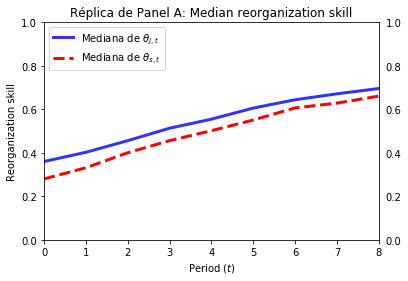

In [36]:
fig, ax = plt.subplots()

#fiz com 9 para ficar igual ao dos autores
X = range(9)



ax.plot(X, Median_j, '-b', linewidth = 3, alpha = 0.8, label = 'Mediana de $θ_{j,t}$')
ax.plot(X, Median_s, '--r', linewidth=3, alpha=1, label = "Mediana de $ θ_{s,t}$")


plt.ylim(0, 1)
plt.xlim(0, 8)

# ax.yaxis.tick_right()
# ax.yaxis.set_ticks_position('both')

#para mostrar ticks dos dois lados do eixo y
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')



#legenda e labels

plt.xlabel("Period $(t)$")
plt.ylabel("Reorganization skill")

ax.set_title("Réplica de Panel A: Median reorganization skill")
ax.legend(loc = 'upper left')
plt.show()


(0, 1)

(0, 8)

Text(0.5, 0, 'Period $(t)$')

Text(0, 0.5, 'Reorganization value')

Text(0.5, 1.0, 'Réplica de Panel B: Median reorganization value')

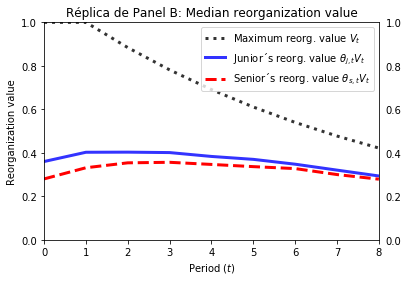

In [37]:
#Panel B:
#Valor de reorganização no eixo y, período no eixo x
#aqui precisamos adicionar o valor de reorganização no eixo y. Ele tem o mesmo valor em t = 0 e t = 1


#vamos criar o valor máximao de reorganização usando 9 períodos

V_graf = Vt(Vmax, 9, ρ)


fig, ax = plt.subplots()

#fiz com 9 para ficar igual ao dos autores
X = range(9)



#valor máximo de reorganização de cada um - sem contar os custos
ax.plot(X, V_graf, ':k', linewidth = 3, alpha = 0.8, label = 'Maximum reorg. value $V_t$')
ax.plot(X, Median_j * V_graf, '-b', linewidth = 3, alpha = 0.8, label = 'Junior´s reorg. value $θ_{j,t} V_t$')
ax.plot(X, Median_s * V_graf, '--r', linewidth=3, alpha=1, label = "Senior´s reorg. value $ θ_{s,t} V_t$")


plt.ylim(0, 1)
plt.xlim(0, 8)

# ax.yaxis.tick_right()
# ax.yaxis.set_ticks_position('both')

#para mostrar ticks dos dois lados do eixo y
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')




plt.xlabel("Period $(t)$")
plt.ylabel("Reorganization value")

ax.set_title("Réplica de Panel B: Median reorganization value")

#achei melhor no upper right
ax.legend(loc = 'upper right')
plt.show()



#### Página 41, Figure 3: Optimal Business Plan

Gráficos da página 41, que mostram o tipo de oferta (liquidar, reorganizar ou esperar) do credor sênior em t = 0. Eixo x é a habilidade verdadeira do credor s e eixo y é o lower bound da habilidade de j.

In [163]:
#parâmetros da tabela 1, Panel B. 

#peguei as médias dos valores

# #V0/L
# 1.592/0.397

# L_mean = 1/ (1.592/0.397)
# L_mean


# #V0/Dj
# 1.592/0.559

# Dj_mean = 1 / (1.592/0.559)
# Dj_mean

# #Ds
# Ds_mean = Dj_mean/0.559 - Dj_mean
# Ds_mean

In [94]:
#a proposta de s vem da função St

#o tamanho do grid depende da habilidade inicial

grid_graf = len(θs_vals)


graf1 = np.empty((grid_graf, grid_graf))

for i, θs in enumerate(θs_vals):
    for j, lj in enumerate(lj_vals):
        graf1[i,j] = St(θs, θs, lj, 2)[1]
            
                



Text(0.5, 1.0, 'Proposta')

Text(0.5, 0, '$θ_s$')

Text(0, 0.5, '$l_j$')

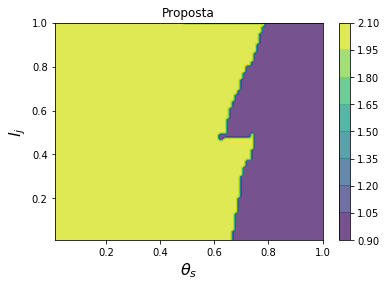

In [95]:
fig, ax = plt.subplots()

cs1 = ax.contourf(θs_vals, lj_vals, graf1.T, alpha=0.75)
# ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
# plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax = ax)

ax.set_title("Proposta")
ax.set_xlabel("$θ_s$", fontsize=16)
ax.set_ylabel("$l_j$", fontsize=16)

ax.ticklabel_format(useOffset=False)


plt.show()



Debugar o fato de St() não gerar uma função contínua

In [48]:
#não está contínuo!


St(1, 1, 0.5, 0)[1]
St(1, 1, 0.9, 0)[1]
St(1, 1, 1, 0)[1]

1

0

1

In [58]:
#payoff de S quanto ele tem o direito de propor em t

 
#Tem que ter preparado o terreno antes calculando as funções valor no período seguinte

def St(teta_st, lst, ljt, t):
    
    #update do lower bound:
    
    #ls_next é a habilidade dele hoje, pois s revela esta quando propõe
    
    ls_next = teta_st
    
      
    
    #quanto s pagará para j neste período? A esperança da função valor de j amanhã,
    #calculadas de acordo com os lower bounds de amanhã
    
    
    #tem expec_beta porque eu não sei o valor de θjt+1, então estimo usando a informação de hoje
    Pst = Ewj(expec_beta(ljt), ls_next, ljt, t+1)
    
    
    #lj_next depende do cutoff de j
    
    #algoritmo para calcular cutoff
    
    cjt = ljt
    
    
    #flag vai parar o loop se demorar muito
    flag = 1
    tol = 0.01
    
    #condição cjt < 0.99 é pra ele não passar de 1
    #veja o que acontece com st(0.28, 0.51, 0.28, 14) se não tiver essa condição
    while (Pst - Ewj(cjt, ls_next, cjt, t+1) > tol and flag < 10000 and cjt < 0.99):
        cjt = cjt + 0.01
        flag = flag + 1
        
    
    #lj_next é o máximo entre o lower bound de j hoje e o cutoff de j
    lj_next = max(ljt, cjt)
    
    #aqui calculamos a oferta ótima de novo, pois pode ser que o cutoff seja maior que o lower bound anterior
    #vou deixar sem recalcular. Assim, é como se o pagamento fosse função de ljt
    
#     Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)
    
    #esperança da própria habilidade no próximo período
    θs_next = expec_beta(teta_st)
    
    #OLHAR ESSA PARTE COM CUIDADO, CONFERIR OS ARGUMENTOS DAS FUNÇÕES NO PERÍODO SEGUINTE
    #conferi em 05/08 e parece OK
    St = [Ls(t), V[t] * θs_next - Pst, Ews(θs_next, ls_next, lj_next, t+1)]
          
    
    policy_St = np.argmax(St)
    
    
    #retorna um vetor: a função valor, a política ótima, o ls_next, e o lj_next
    return St[policy_St],policy_St, ls_next, lj_next



In [85]:
#checando output completo
St(1,1,0.5,0)

#checando valor esperado do theta_s para amanha
expec_beta(1)

#pegando valores de ls_next, lj_next, e ljt
ljt = 0.5
ls_next = 1
lj_next = 0.54

#checando valor do pagamento
Ewj(expec_beta(ljt), ls_next, ljt, 1) 


#checando valor que faz o threshold funfar
Ewj(lj_next, ls_next, lj_next, 1)

#checando os argumentos de St
Ls(0)

V[0] * expec_beta(1) - Ewj(expec_beta(ljt), ls_next, ljt, 1)

#o valor de continuação dele para o próximo período está dando 0, esquisito isso.
Ews(expec_beta(1), ls_next, lj_next, 1)




(0.42627761527497976, 1, 1, 0.54)

1

0.5737223847250202

0.567109781054879

0.25

0.42627761527497976

0.0

Checando Ews(1, 1, 0.54, 1)

In [128]:
#checando valor de continuação quando teta_s é igual a 1

#valor esperado das funções valor, já organizado

def Ews(teta_hoje, ls_amanha, lj_amanha, t):
    #t é o período para o qual queremos o valor esperado
    #t igual a "t_amanhã"
#     breakpoint()
    if t == T:
        return Ls(T)
    else:
    
        teta_hoje = find(teta_hoje)

        ls_amanha = find(ls_amanha)
        lj_amanha = find(lj_amanha)
    
    
        
        Esp_respondendo = sum(pmf[teta_hoje, teta_hoje:100] * Ws_array[teta_hoje:100,ls_amanha, lj_amanha, 0, (t-1) ])
        Esp_propondo = sum(pmf[teta_hoje, teta_hoje:100] * Ws_array[teta_hoje:100,ls_amanha, lj_amanha, 1, (t-1) ])


        Esp = λj * Esp_respondendo + (1 - λj) * Esp_propondo

        return Esp

In [130]:
Ews(expec_beta(1), ls_next, lj_next, 1)

#Esp_respondendo = 0.0


#pmf dá zero
# pmf[teta_hoje, teta_hoje:100]
# array([0.])

#Quando s propõe, o penúltimo argumento é 1. Parece estar OK
# Ws_array[teta_hoje:100,ls_amanha, lj_amanha, 1, (t-1) ]
# array([0.48577883])


#Quando s responde, o penúltimo argumento é 0. Parece ter erro, mesmo que a firma seja liquidada em t=1, s recebe.
# Ws_array[teta_hoje:100,ls_amanha, lj_amanha, 0, (t-1) ]
# array([0.])

#acho que se o resultado da pmf fosse 1, ele multiplicaria por 0.48 e ia ficar sussa

st(1,1,0.54, 2)

0.3176993571113398

0.24269652228837815

In [ ]:
#checando função pmf

#era um problema para popular a pmf. O range só ia até 98, quando precisava da pmf em 99.

In [112]:
#checando st(1, 1,0.5, 1)

st(1,1,0.5, 1)

0.2768146999629565

In [88]:
Ls(1)

0.21283000000000002

In [45]:
#gráfico B: proposta do credor Júnior em t = 0

graf2 = np.empty((grid_graf, grid_graf))

for i, θs in enumerate(θs_vals):
    for j, lj in enumerate(lj_vals):
        graf2[i,j] = Jt(θs, lj, θs, 0)[1]
        
        


Text(0.5, 1.0, 'Proposta')

Text(0.5, 0, '$θ_j$')

Text(0, 0.5, '$l_s$')

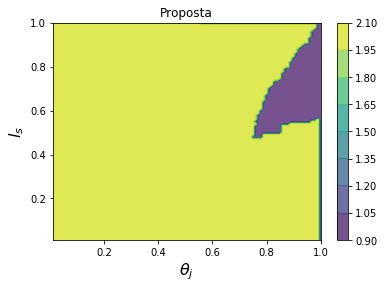

In [47]:
fig, ax = plt.subplots()

cs1 = ax.contourf(θs_vals, lj_vals, graf2.T, alpha=0.75)
# ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
# plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax = ax)

ax.set_title("Proposta")
ax.set_xlabel("$θ_j$", fontsize=16)
ax.set_ylabel("$l_s$", fontsize=16)

ax.ticklabel_format(useOffset=False)


plt.show()

# Próximos passos



* HIGIENIZAR O CÓDIGO, DEIXAR ORGANIZADO!


* ~debugar o que acontece quando t = 14~
    * bug na função pmf, e acho que vem da função bins() também


* ~criar função de esperança baseada na função beta~
    * expec_beta(info_hoje) retorna o valor esperado de teta amanhã




* ~discretizar a beta para obter a esperança das funções valor no período seguinte~



* ~fazer Js_val~

* ~guardar resultados de Js_val e Ws_val do último período numa  matriz 4D~

* ~pensar numa função Js_next para achar o valor de Js no próximo período baseado nos parâmetros deste período~
    * regra para atualização de lst
    * regra para atualização de ljt
    * expectativa da habilidade no período seguinte

* ~pensar na forma recursiva do jogo~
    * acho que as funções probabilidade também têm que considerar o update do lower bound, pois elas fazem parte do cenário onde o jogador não propõe


* checar todas as funções de cálculo do jogo (Passo 3)


* considerar a estrutura de negociação do jogo

* aumentar a precisão das estimativas do jogo
    * algoritmo para cálculo do cutoff pode ter mais casas decimais
    
    
 * fazer uma estrutura mais enxuta, com uma função que tome como argumento se é s ou j. Ao invés de criar St, Jt, st, jt...
    


* passos finais
    * replicar os gráficos do artigo de referência


### Conferir novamente

1. ~Se preciso usar ls_next e lj_next nas funções Prob_s e Prob_j~ 
   * conferi e precisa sim, já arrumei

2. Se o valor esperado da função para calcular os thresholds cst e cjt estão corretos

3. A função pmf não está somando um, tem que verificar onde está o erro

